In [1]:
from bs4 import BeautifulSoup
import requests
import csv
import pandas as pd
import numpy as np
import re
from simplemma import text_lemmatizer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
import pickle

In [2]:
url_Ürünler = [
    
   
    "https://www.trendyol.com/erkek-giyim-x-g2-c82?pi=",
    "https://www.trendyol.com/erkek-aksesuar-x-g2-c27?pi="
]

urun_ismi_ve_link = []  

for urlm in url_Ürünler:
    url_template = urlm + "{page_number}"
    link_basi = "https://www.trendyol.com/"


    for page_number in range(1,208):
        url = url_template.format(page_number=page_number)
        page = requests.get(url)
        content = page.content
        html = BeautifulSoup(content, "html.parser")

        main_page = html.find("div", class_="prdct-cntnr-wrppr")
        ul = main_page.find_all("div")

        for urun in ul:
            li = urun.find_all("div", class_="p-card-chldrn-cntnr card-border")
            for i in li:
                a = i.find("a")
                link_sonu = a.get("href")

                # ürün linki
                urun_link = link_basi + link_sonu
                try:
                    urun_sayfasi = requests.get(urun_link)
                    urun_sayfasi.raise_for_status()  
                    
                    urun_soup = BeautifulSoup(urun_sayfasi.content, "html.parser")

                    # ürün ismi çekme
                    urun_ismi = urun_soup.find("h1", class_="pr-new-br")
                    if urun_ismi:
                        urun_spanlar = urun_ismi.find_all("span")

                       
                        if urun_spanlar:
                            
                            if len(urun_spanlar) == 1:
                                urun_ismi_str = urun_spanlar[0].text.strip()
                            elif len(urun_spanlar) == 2:
                                urun_ismi_str = urun_spanlar[1].text.strip()
                    else:
                        urun_ismi_str = "Ürün İsmi Bulunamadı"
                        
                        continue  

                    # fiyat  çekme
                    urun_fiyatlari = urun_soup.find("span", class_="prc-dsc")
                    if urun_fiyatlari:
                        urun_fiyat = urun_fiyatlari.text.split()[0]
                    else:
                        urun_fiyat = "Değerlendirme Bulunamadı"

                    # ürün kategori türünü çekme
                    urun_kategori_div = urun_soup.find("div", class_="product-detail-breadcrumb full-width")
                    if urun_kategori_div:
                        urun_kategori = urun_kategori_div.select("a.product-detail-breadcrumb-item")[3].text.strip()
                    else:
                        urun_kategori = "Kategori bulunamadı"
                        continue

                    # ürün ismi, linki ,fiyatı ve kaategorini listeye ekleme
                    urun_ismi_ve_link.append({"Ürün İsmi": urun_ismi_str, "Ürün Linki": urun_link, "Ürün Fiyatı": urun_fiyat, "Kategori": urun_kategori})
                    

                except requests.RequestException as e:
                  continue
# CSV dosyasına yazma
csv_file_path = "urun_detaylari.csv"
with open(csv_file_path, mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(["Ürün İsmi", "Ürün Linki", "Ürün Fiyatı", "Kategori"])  
    for urun in urun_ismi_ve_link:
        writer.writerow([urun["Ürün İsmi"], urun["Ürün Linki"], urun["Ürün Fiyatı"], urun["Kategori"]])
        


In [3]:
df = pd.read_csv("urun_detaylari.csv")
df.head(-10)

,Ürün İsmi,Ürün Linki,Ürün Fiyatı,Kategori
0,Siyah Pileli Baggy Kumaş Pantolon MOO1074,https://www.trendyol.com//menofourswear/siyah-...,"333,55",Pantolon
1,Boyfriend Asit Yıkamalı Taşlamalı Buz Mavisi K...,https://www.trendyol.com//wamoss/boyfriend-asi...,"200,11",Pantolon
2,Erkek Siyah Renk Italyan Kesim Kaliteli Esnek ...,https://www.trendyol.com//burke/erkek-siyah-re...,"369,99",Pantolon
3,Erkek Siyah %100 Pamuk Slim Fit Dar Kesim Bisi...,https://www.trendyol.com//ac-co-altinyildiz-cl...,"154,99",T-Shirt
4,Slim Fit Kolay Ütü Teri Emen Nefes Alan Doku K...,https://www.trendyol.com//tudors/slim-fit-kola...,"199,99",Gömlek
...,...,...,...,...
8969,2'li Erkek Klasik Kemer 0002,https://www.trendyol.com//genuine-leather-comp...,"229,99",Kemer Pantolon Askısı
8970,Erkek Kahverengi Orta Sarma Deri Çift Halatlı ...,https://www.trendyol.com//mrhero/erkek-kahvere...,"130,04",Takı & Mücevher
8971,Erkek Kol Saati DKBSRN4259798,https://www.trendyol.com//daniel-klein/erkek-k...,"1.549,90",Saat
8972,Erkek Kasket Siyah Beyaz Çizgili Yün Kışlık Şa...,https://www.trendyol.com//capstories/erkek-kas...,"329,90",Şapka


In [4]:
#verileri filtrele

df = pd.read_csv("urun_detaylari.csv")
stop_words = None
with open("stopwords2.txt", "r") as stop_file:
    stop_words = set(stop_file.read().splitlines())

def clean(text):
    text = text.replace("Â", "a")
    text = text.replace("â", "a")
    text = text.replace("î", "i")
    text = text.replace("Î", "ı")
    text = text.replace("İ", "i")
    text = text.replace("I", "ı")
    text = text.replace(u"\u00A0", " ")
    text = text.replace("|", " ")

    text = re.sub(r"@[A-Za-z0-9]+", " ", text)
    text = re.sub(r"(.)\1+", r"\1\1", text)
    text = re.sub(r"https?:\/\/\S+", " ", text)
    text = re.sub(r"http?:\/\/\S+", " ", text)
    text = re.sub(r"\n", " ", text)
    text = re.sub(r"#(\w+)", " ", text)
    text = re.sub(r"^\x00-\x7F]+", " ", text)
    text = re.sub(r"[^A-Za-zâîığüşöçİĞÜŞÖÇ]+", " ", text)
    text = re.sub(r"((https://[^\s]+))", " ", text)

    text = " ".join(text.lower().strip().split())
    text = text_lemmatizer(text, lang="tr")

    return " ".join([word for word in text if word not in stop_words])

In [5]:
#temizleyip kaydetme işlemi
csv_file_path = "urun_detaylari.csv"
cleaned_data_list = []

# CSV dosyasını oku ve temizleme işlemi uygula
with open(csv_file_path, mode='r', encoding='utf-8') as file:
    reader = csv.reader(file)
    header = next(reader) 
    for row in reader:
        if row:
         
            cleaned_comment = clean(row[0])
            row[3] = row[3].strip()

            if cleaned_comment is not None:
                
                cleaned_data_list.append([row[0],row[3],cleaned_comment])

# Temizlenmiş verileri yeni bir CSV dosyasına yaz
cleaned_csv_file_path = "cleaned_data.csv"
with open(cleaned_csv_file_path, mode='w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerow(["Ürün İsmi", "Kategori", "Temizlenmiş"])
    for cleaned_data in cleaned_data_list:
        writer.writerow(cleaned_data)

In [6]:
#temişlenmiş veri kontrolü yazdırılması
df = pd.read_csv("cleaned_data.csv")
df.head(-10)

,Ürün İsmi,Kategori,Temizlenmiş
0,Siyah Pileli Baggy Kumaş Pantolon MOO1074,Pantolon,siyah pileli baggy kumaş pantolon moo
1,Boyfriend Asit Yıkamalı Taşlamalı Buz Mavisi K...,Pantolon,boyfriend asit yıka taşla buz mavi kot pantolo...
2,Erkek Siyah Renk Italyan Kesim Kaliteli Esnek ...,Pantolon,erkek siyah renk ıtalyan kesim kalite esnek li...
3,Erkek Siyah %100 Pamuk Slim Fit Dar Kesim Bisi...,T-Shirt,erkek siyah pamuk slim fit dar kesim bisiklet ...
4,Slim Fit Kolay Ütü Teri Emen Nefes Alan Doku K...,Gömlek,slim fit kolay ütü ter em nefes al doku kravat...
...,...,...,...
8969,2'li Erkek Klasik Kemer 0002,Kemer Pantolon Askısı,erkek klasik kemer
8970,Erkek Kahverengi Orta Sarma Deri Çift Halatlı ...,Takı & Mücevher,erkek kahverengi orta sar deri çift halat el y...
8971,Erkek Kol Saati DKBSRN4259798,Saat,erkek kol saat dkbsrn
8972,Erkek Kasket Siyah Beyaz Çizgili Yün Kışlık Şa...,Şapka,erkek kasket siyah beyaz çizgi yün kışlık şapk...


In [7]:

df = pd.DataFrame(urun_ismi_ve_link)

# Temizleme ve etiketleme
df["Temiz"] = df.apply(lambda row: clean(row["Ürün İsmi"]), axis=1)

# Kategorilere benzersiz etiketlerini oluşturm işlemi
kategori_etiketleri_liste = list(df["Kategori"].unique())

df = pd.read_csv("cleaned_data.csv")
# Her bir ürünün kategorisini etiketleme işlemi
df["Etiket"] = df["Kategori"].map(dict(zip(kategori_etiketleri_liste, range(len(kategori_etiketleri_liste)))))
 

# CSV dosyasına yazma işlemi
csv_file_path = "cleaned_data.csv"
df.to_csv(csv_file_path, index=False)

# Kategori etiketlerini liste olarak yazdırma işlemi
print("Kategori Etiketleri:", kategori_etiketleri_liste)

# Sonuçları yazdırma
df.head(10)

Kategori Etiketleri: ['Pantolon', 'T-Shirt', 'Gömlek', 'Sweatshirt', 'Kemer Pantolon Askısı', 'Saat', 'Cüzdan & Kartlık', 'Saat Seti', 'Şapka', 'Takı & Mücevher']


,Ürün İsmi,Kategori,Temizlenmiş,Etiket
0,Siyah Pileli Baggy Kumaş Pantolon MOO1074,Pantolon,siyah pileli baggy kumaş pantolon moo,0
1,Boyfriend Asit Yıkamalı Taşlamalı Buz Mavisi K...,Pantolon,boyfriend asit yıka taşla buz mavi kot pantolo...,0
2,Erkek Siyah Renk Italyan Kesim Kaliteli Esnek ...,Pantolon,erkek siyah renk ıtalyan kesim kalite esnek li...,0
3,Erkek Siyah %100 Pamuk Slim Fit Dar Kesim Bisi...,T-Shirt,erkek siyah pamuk slim fit dar kesim bisiklet ...,1
4,Slim Fit Kolay Ütü Teri Emen Nefes Alan Doku K...,Gömlek,slim fit kolay ütü ter em nefes al doku kravat...,2
5,Erkek Yeni Sezon Kışlık Baggy Pantolon 1.kalit...,Pantolon,erkek yeni sezon kışlık baggy pantolon kalite ...,0
6,Bej Slimfit Hediye Kutulu Gerçek Kot Gömlek 1815,Gömlek,bej slimfit hediye kutu gerçek kot gömlek,2
7,Erkek Beyaz %100 Pamuk Slim Fit Dar Kesim Bisi...,T-Shirt,erkek beyaz pamuk slim fit dar kesim bisiklet ...,1
8,Slim Fit Kolay Ütü Teri Emen Nefes Alan Doku K...,Gömlek,slim fit kolay ütü ter em nefes al doku kravat...,2
9,Erkek Regular Fit Kışlık Kaşe Gömlek 2632,Gömlek,erkek regular fit kışlık kaşe gömlek,2


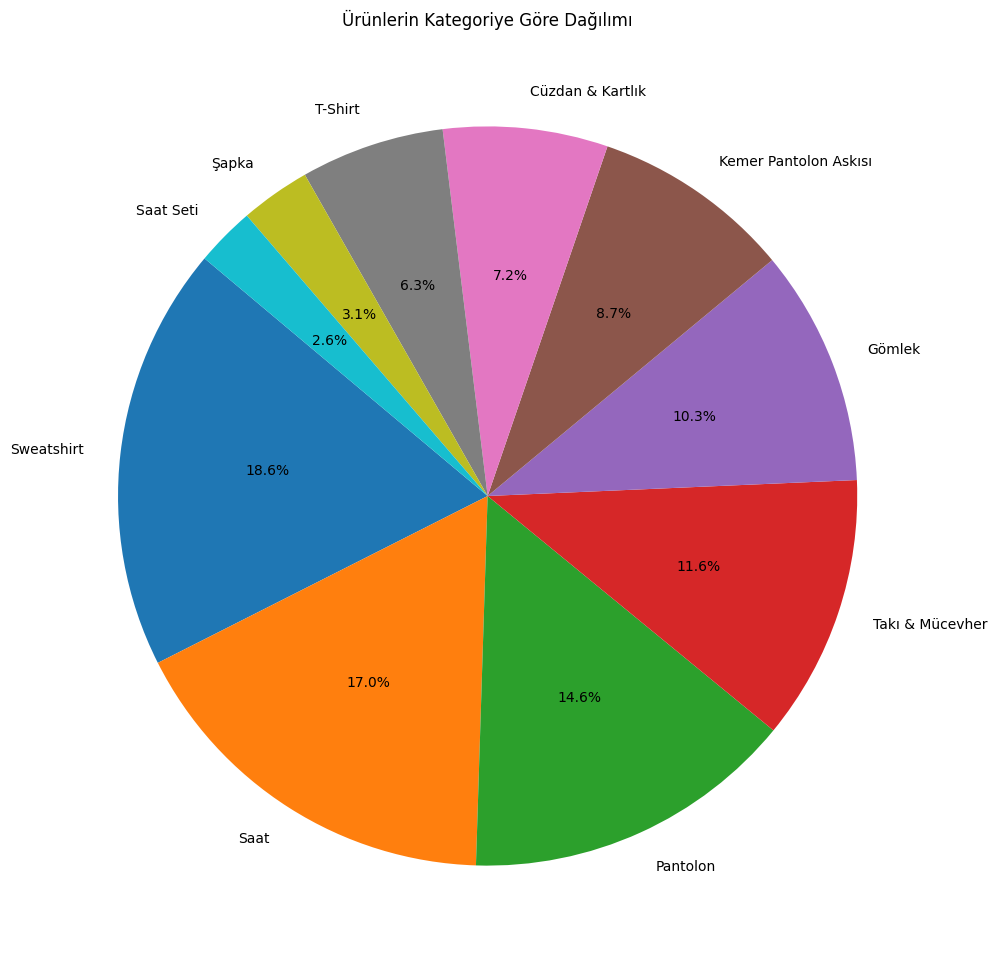

In [8]:
df = pd.DataFrame(urun_ismi_ve_link)

# Her bir kategori için kaç ürün olduğunu saym işlemi
kategori_sayilari = df['Kategori'].value_counts()

# Pasta grafiğini çiz
plt.figure(figsize=(12, 12))
plt.pie(kategori_sayilari, labels=kategori_sayilari.index, autopct='%1.1f%%', startangle=140)
plt.title('Ürünlerin Kategoriye Göre Dağılımı')
plt.show()

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'Cüzdan & Kartlık'),
  Text(1, 0, 'Gömlek'),
  Text(2, 0, 'Kemer Pantolon Askısı'),
  Text(3, 0, 'Pantolon'),
  Text(4, 0, 'Saat'),
  Text(5, 0, 'Saat Seti'),
  Text(6, 0, 'Sweatshirt'),
  Text(7, 0, 'T-Shirt'),
  Text(8, 0, 'Takı & Mücevher'),
  Text(9, 0, 'Şapka')])

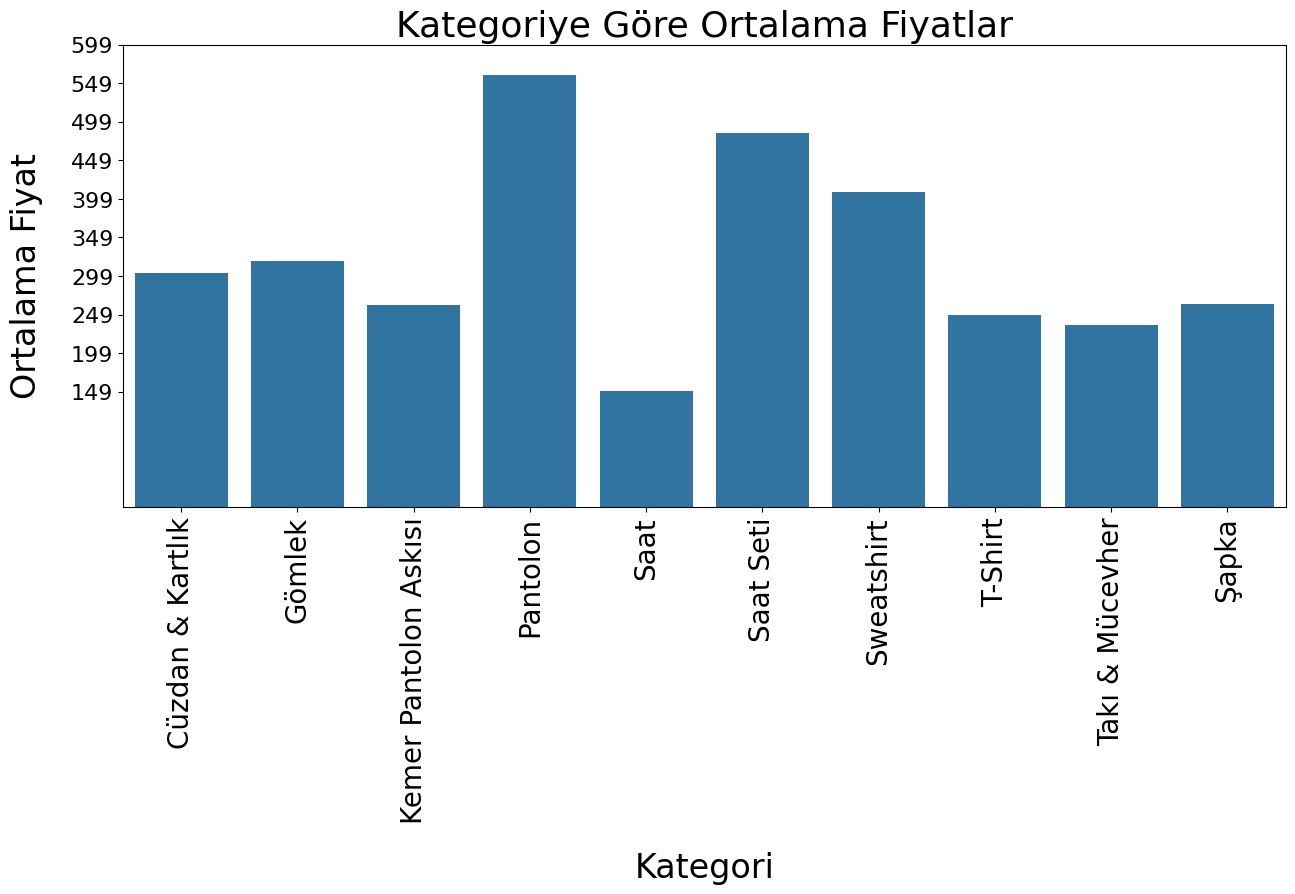

In [9]:
#Burada kategoriye Göre Ürün ortalama fiyat Grafiklerini Göreceğiz

df = pd.DataFrame(urun_ismi_ve_link)

df['Ürün Fiyatı'] = pd.to_numeric(df['Ürün Fiyatı'], errors='coerce')

# Kategori bazlı ortalama fiyatları çıkartma
ortalama_fiyatlar = df.groupby('Kategori')['Ürün Fiyatı'].mean().reset_index()

#Hiç bulunmayan kategorilerde Nan Dönenler için Listeden çıkarma
ortalama_fiyatlar_cleaned = ortalama_fiyatlar.dropna(subset=['Ürün Fiyatı'])


# Çubuk grafiği çizme
plt.figure(figsize=(15, 6))
sns.barplot(x='Kategori', y='Ürün Fiyatı', data=ortalama_fiyatlar)

#Ortalama minimum fiyat alma 
min_y = min(ortalama_fiyatlar_cleaned['Ürün Fiyatı'])

#Ortalama maximum fiyat alma
max_y = max(ortalama_fiyatlar_cleaned['Ürün Fiyatı'])

#Fiyat artış oranı 50 şer 50 şer artma
tick_step = 50 

ytick_positions = range(int(min_y), int(max_y) + tick_step, tick_step)
plt.yticks(ytick_positions)


# Grafiği gösterme işlemi
plt.title('Kategoriye Göre Ortalama Fiyatlar',fontsize=26) 
plt.xlabel('Kategori', fontsize=24, labelpad=20)
plt.ylabel('Ortalama Fiyat', fontsize=24, labelpad=20)
plt.yticks(fontsize=16) 
plt.xticks(fontsize=20, rotation=90)  


In [11]:
#Model Eğitme

# MODEL 1 (Karar Ağacı modeli) Veriyi okuma işlemi
df = pd.read_csv("cleaned_data.csv")

# Veriyi özellikler (X) ve etiketler (y) olarak ayırma işlemi
X = df["Temizlenmiş"].to_numpy()
y = df["Etiket"].astype('category').cat.codes.to_numpy()

# Veriyi eğitim ve test setlerine bölme işlemi
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TF-IDF vektörleme işlemi
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)


clf = DecisionTreeClassifier(max_depth=5, min_samples_split=2, min_samples_leaf=1)
clf.fit(X_train, y_train)

# Test setinde modelin performansı
accuracy = clf.score(X_test, y_test)
print(f"Model Doğruluğu: {accuracy}")

Model Doğruluğu: 0.7774067890929327


In [12]:
# MODEL 2 (NaiveBayes modeli) Veriyi okuma işlemi
df = pd.read_csv("cleaned_data.csv")

# Veriyi özellikler (X) ve etiketler (y) olarak ayır
X = df["Temizlenmiş"].to_numpy()
y = df["Etiket"].astype('category').cat.codes.to_numpy()

# Veriyi eğitim ve test setlerine böl
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# TF-IDF vektörleme işlemi
vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# MultinomialNB modelini oluştur ve eğit
clf = MultinomialNB()
clf.fit(X_train_tfidf, y_train)

# Test setinde modelin performansını değerlendir
accuracy = clf.score(X_test_tfidf, y_test)
print(f"Model Doğruluğu: {accuracy}")

Model Doğruluğu: 0.9499165275459098


In [14]:
#Verilen girdinin kategorisini ve fiyatını tahmin etme metodu
def tahmin_et(veri):
    yeni_metin =  veri
    cl=clean(yeni_metin)
    yeni_metin_tfidf = vectorizer.transform([cl])
    tahmin_indeks = clf.predict(yeni_metin_tfidf.toarray())[0]
    tahmin_edilen_kategori = kategori_etiketleri_liste[tahmin_indeks]
    secilen_kategori = "Örnek Kategori" 
    kategori_ortalama_fiyat = ortalama_fiyatlar.loc[ortalama_fiyatlar['Kategori'] == tahmin_edilen_kategori, 'Ürün Fiyatı'].iloc[0]

    print(f" Girdiğiniz ürünün tahmin edilen kategorisi - {tahmin_edilen_kategori} - ve ortalama piyasa fiyatı {kategori_ortalama_fiyat:.2f} ₺ olarak görülmektedir.")

In [19]:
tahmin_et("Düğmeli Yaka Kolay Ütülenebilir Pamuklu Slim Fit Dar Kesim Oxford Haki Gömlek 4A2021100103HAK")
tahmin_et("Yarım Balıkçı Yaka Düz Yeşil Erkek Sweatshırt SPBF3WM-SWT5006")
tahmin_et("GR-010-02627-04 Instinct 2 Solar Tactical Edition - Coyote Tan Akıllı Saat ")
tahmin_et("Efsane görülmemiş kumaş hint kumaşı mükemmel  gel vatandaş mükemmel erkek kot pantolon")
tahmin_et("Kdon pamuklu Siyah Regular Fit bisiklet dikişsiz Yaka T-shirt 2053004")

 Girdiğiniz ürünün tahmin edilen kategorisi - Gömlek - ve ortalama piyasa fiyatı 318.77 ₺ olarak görülmektedir.
 Girdiğiniz ürünün tahmin edilen kategorisi - Sweatshirt - ve ortalama piyasa fiyatı 407.41 ₺ olarak görülmektedir.
 Girdiğiniz ürünün tahmin edilen kategorisi - Saat - ve ortalama piyasa fiyatı 149.31 ₺ olarak görülmektedir.
 Girdiğiniz ürünün tahmin edilen kategorisi - Pantolon - ve ortalama piyasa fiyatı 559.21 ₺ olarak görülmektedir.
 Girdiğiniz ürünün tahmin edilen kategorisi - T-Shirt - ve ortalama piyasa fiyatı 248.43 ₺ olarak görülmektedir.
